Run a simple test on the ROI pooling operation. Given a sample image, we perform the ROI pooling operation given the image and a sample ROI. We then crop the image to that ROI and run it through a normal max pooling layer. If the outputs are the same, the test has succeeded. 

In [1]:
import numpy as np
import PIL
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops

import time
from operator import mul
from functools import reduce

import os
home = os.getenv("HOME")

In [2]:
# Since we've added custom operations, we need to import them. Tensorflow does not automatically add custom ops.
# Adjust the paths below to your tensorflow source folder.

# Import the forward op
roi_pooling_module = tf.load_op_library(
    home + "/packages/tensorflow/bazel-bin/tensorflow/core/user_ops/roi_pooling_op.so")
roi_pooling_op = roi_pooling_module.roi_pooling

# Import the gradient op
roi_pooling_module_grad = tf.load_op_library(
    home + "/packages/tensorflow/bazel-bin/tensorflow/core/user_ops/roi_pooling_op_grad.so")
roi_pooling_op_grad = roi_pooling_module_grad.roi_pooling_grad

In [3]:
# Set up a Tensorflow session
sess = tf.InteractiveSession()

In [4]:
# Get the input image 
image_width = 475
image_height = 360
input_image = Image.open("cat.png").convert("L").crop((0, 0, image_width, image_height))
# Should be in NCHW format (num batches, num channels, height, width)
input_array = np.asarray(input_image).reshape(1, 1, image_height, image_width)

# Get the cropped input image
input_image_cropped = Image.open("cat.png").convert("L").crop((0, 0, 400, 300))
input_image_cropped = np.asarray(input_image_cropped)
input_array_nhwc = input_image_cropped.reshape(1, 300, 400, 1)


In [13]:
# Set up the operations
def test(device):
    with tf.device("/{}:0".format(device)):
        # Set up the inputs
        data_constant = tf.constant(input_array.astype(np.float32))
        data_nhwc = tf.constant(input_array_nhwc.astype(np.float32))
        rois_constant = tf.constant([[(0, 0, 300, 400)]])
        output_shape_tensor_constant = tf.constant((30, 40))

        # Compute with the ROI pooling layer
        result, argmax = roi_pooling_op(data_constant, rois_constant, output_shape_tensor_constant)

        # Compute with the max pooling layer on the cropped inputs
        result_max = tf.nn.max_pool(data_nhwc, ksize=[1, 10, 10, 1], strides=[1, 10, 10, 1], padding="VALID")
        
        # Reshape the results to an image and return
        return result.eval().reshape((30, 40)), result_max.eval().reshape((30, 40))

In [14]:
# Evaluate the operations
roi_pooling, max_pooling = test("gpu")

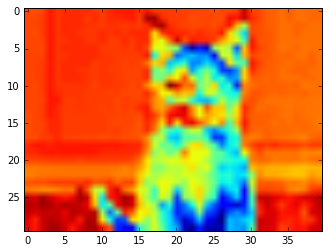

In [15]:
# Output computed with the ROI pooling layer
plt.imshow(roi_pooling);

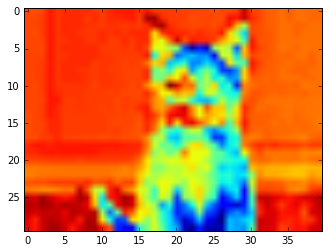

In [16]:
# Output computed with the max pooling layer
plt.imshow(max_pooling);

In [17]:
# Confirm that the results are indeed essentially identical
np.allclose(roi_pooling, max_pooling, rtol=.01)

True

In [18]:
# Do the test for the CPU implementation also
roi_pooling, max_pooling = test("cpu")
np.allclose(roi_pooling, max_pooling, rtol=.01)

True